## Aufgabe 2
### Datenanalyse

In [19]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
# TODO Delete
DATA_DIR = Path("..", "data")
RAW, OUT = DATA_DIR / "raw", DATA_DIR / "processed"

In [43]:
df_nasdaq_daily_pp = pd.read_csv(OUT / "df_nasdaq_daily.csv", keep_default_na=False)
df_nasdaq_daily_pp["date"] = pd.to_datetime(df_nasdaq_daily_pp["date"])

df_nasdaq_weekly_pp = pd.read_csv(OUT / "df_nasdaq_weekly.csv", keep_default_na=False)

df_crypto_daily_pp = pd.read_csv(OUT / "df_crypto_daily.csv", keep_default_na=False)
df_crypto_daily_pp["date"] = pd.to_datetime(df_crypto_daily_pp["date"])

df_crypto_weekly_pp = pd.read_csv(OUT / "df_crypto_weekly.csv", keep_default_na=False)

df_nasdaq_meta_pp = pd.read_csv(OUT / "df_nasdaq_meta.csv", keep_default_na=False)

Average years of a company in NASDAQ: 11.325328939278425


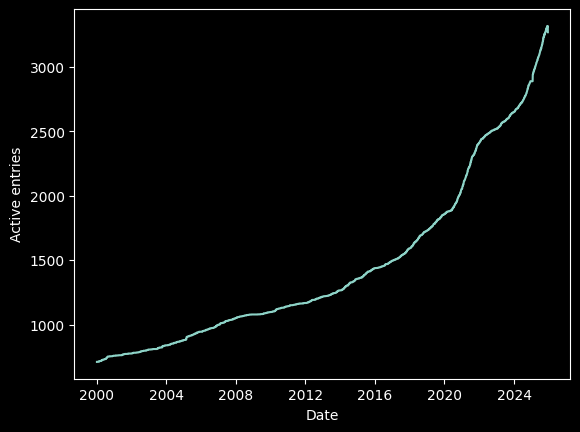

In [23]:
df_nasdaq_first_last = (df_nasdaq_daily_pp.groupby("ticker")["date"]
      .agg(firstdate="min", lastdate="max")
      .reset_index()
)

df_nasdaq_first_last["days"] = (df_nasdaq_first_last["lastdate"] - df_nasdaq_first_last["firstdate"]).dt.days
print("Average years of a company in NASDAQ:", df_nasdaq_first_last.days.mean() / 365)

dates_between = pd.date_range(
    df_nasdaq_first_last["firstdate"].min(),
    df_nasdaq_first_last["lastdate"].max(),
    freq='D'
)

# count active tickers per day
counts = pd.Series(dates_between).apply(lambda d: ((df_nasdaq_first_last.firstdate <= d) & (df_nasdaq_first_last.lastdate >= d)).sum())

plt.plot(dates_between, counts)
plt.xlabel('Date')
plt.ylabel('Active entries')
plt.show()

### NASDAQ Winning Shares per Year

In [41]:
df_nasdaq_yearly = df_nasdaq_daily_pp.copy()

df_nasdaq_yearly["year"] = df_nasdaq_yearly["date"].dt.year

df_nasdaq_yearly = (
    df_nasdaq_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_nasdaq_yearly["win"] = df_nasdaq_yearly["end"] > df_nasdaq_yearly["start"]

s_wins_per_year = df_nasdaq_yearly.groupby("year")["win"].sum() / df_nasdaq_yearly.groupby("year")["ticker"].count()

s_wins_per_year.name="Winning Percentage"

bestyear = s_wins_per_year.idxmax()
print("Best Year:", bestyear)

s_wins_per_year

Best Year: 2003


year
2000    0.377309
2001    0.624516
2002    0.408189
2003    0.904648
2004    0.641638
2005    0.393008
2006    0.662325
2007    0.392959
2008    0.138347
2009    0.706472
2010    0.674256
2011    0.368466
2012    0.637336
2013    0.803162
2014    0.583026
2015    0.484701
2016    0.656856
2017    0.629793
2018    0.331019
2019    0.643319
2020    0.572612
2021    0.533195
2022    0.214768
2023    0.470034
2024    0.515457
2025    0.482924
Name: Winning Percentage, dtype: float64

### Crypto Winning Shares per Year

In [49]:
df_crypto_yearly = df_crypto_daily_pp.copy()

df_crypto_yearly["year"] = df_crypto_yearly["date"].dt.year

df_crypto_yearly = (
    df_crypto_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_crypto_yearly["win"] = df_crypto_yearly["end"] > df_crypto_yearly["start"]

s_crypto_wins_per_year = df_crypto_yearly.groupby("year")["win"].sum() / df_crypto_yearly.groupby("year")["ticker"].count()

s_crypto_wins_per_year.name="Winning Percentage"

s_crypto_wins_per_year

year
2010    1.000000
2011    1.000000
2012    1.000000
2013    1.000000
2014    0.333333
2015    0.500000
2016    0.700000
2017    1.000000
2018    0.111111
2019    0.468085
2020    0.838235
2021    0.907895
2022    0.038095
2023    0.866667
2024    0.771429
2025    0.161905
Name: Winning Percentage, dtype: float64

In [51]:
s_wins_per_year[s_wins_per_year.index >= 2010] - s_crypto_wins_per_year

year
2010   -0.325744
2011   -0.631534
2012   -0.362664
2013   -0.196838
2014    0.249692
2015   -0.015299
2016   -0.043144
2017   -0.370207
2018    0.219907
2019    0.175234
2020   -0.265623
2021   -0.374700
2022    0.176673
2023   -0.396633
2024   -0.255972
2025    0.321019
Name: Winning Percentage, dtype: float64